In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-prediction-dataset/traffic.csv



# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Traffic Prediction</p>

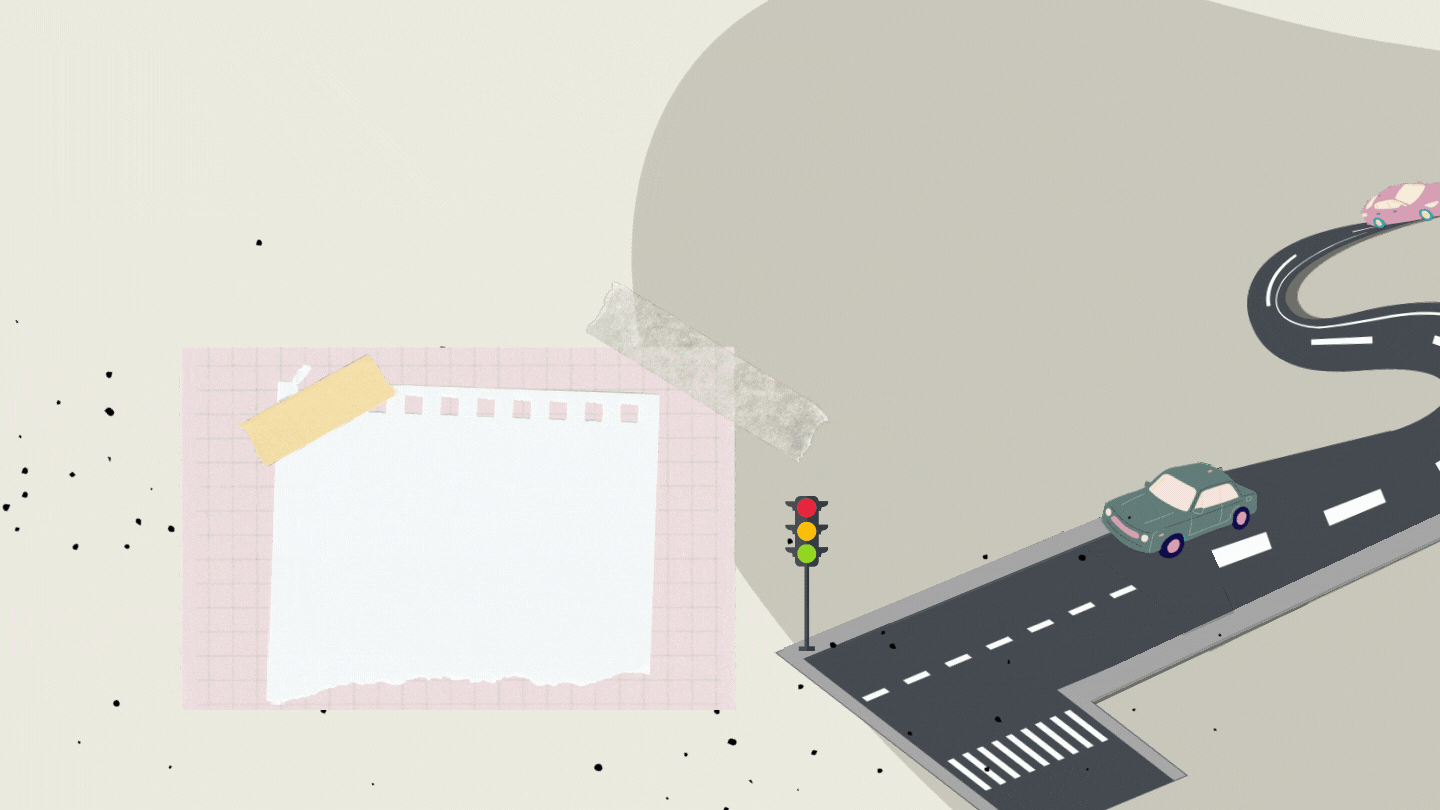


Traffic is one of those annoying problems that affect many of us living in urban settings. One of the causes of traffic is the increase in urban populations. While the infrastructure is old and can only accommodate a limited population there is an influx of residents in search of livelihood and opportunities.

Traffic congestions lead to an increased in the combustion of fuel. It further increases the carbon emissions causing air pollution. It also costs time and money. INRIX's, a transportation analytics and connected car services,  2020 report found that on average, Americans lost 99 hours a year due to congestion, costing them nearly 88 billion dollars in 2019, an average of 1,377 dollars per year. From 2017 to 2019 the average time lost by American drivers has increased by two hours as economic and urban growth continues.  [link](https://inrix.com/press-releases/2019-traffic-scorecard-us/)

In this project, I will be exploring the dataset of four junctions and built a model to predict traffic on the same. This could potentially help in solving the traffic congestion problem by providing a better understanding of traffic patterns that will further help in building an infrastructure to eliminate the problem. 




   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">

# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Table Of Contents</p>
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
    
* [3. DATA EXPLORATION](#3) 
    
    * [3.1 FEATURE ENGINEERING](#3.1)
    * [3.2 EXPLORATORY DATA ANALYSIS](#3.2)

    
* [4. DATA TRANSFORMATION AND PREPROCESSING](#4) 
    
* [5. MODEL BUILDING](#5)
    
* [6. FITTING THE MODEL](#6) 
     
* [7. INVERSING THE TRANSFORMATION OF DATA](#7)
    
* [8. END](#8)


 <a id="1"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Importing Libraries</p>

In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

<a id="2"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Loading Data</p>

In [3]:
#Loading Data
data = pd.read_csv("../input/traffic-prediction-dataset/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


**About the data**

This dataset is a collection of numbers of vehicles at four junctions at an hourly frequency. 
The CSV file provides four features:

* DateTime
* Junctions
* Vehicles
* ID

The sensors on each of these junctions were collecting data at different times, hence the traffic data from different time periods. Some of the junctions have provided limited or sparse data.

<a id="3"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Data Exploration</p>
* Pharsing dates
* Ploting timeseris
* Feature engineering for EDA

In [4]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

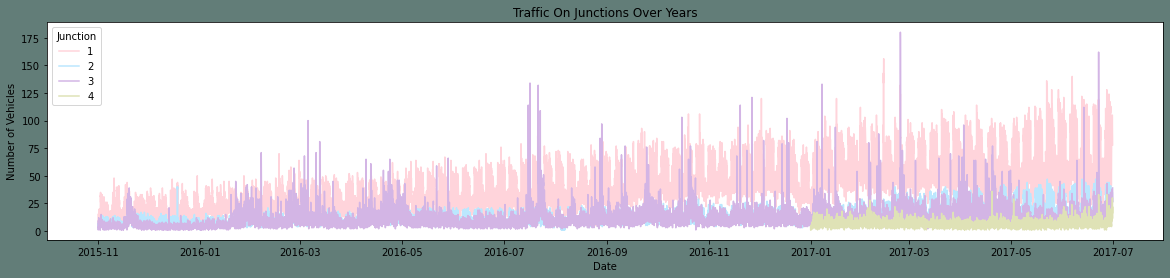

In [5]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

**Noticeable information in the above plot:**

* It can be seen here that the first junction is visibly having an upward trend.
* The data for the fourth junction is sparse starting only after 2017
* Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it. 

<a id="3.1"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Feature Engineering</p>

At this step, I am creating a few new features out of DateTime. 
Namely:
* Year
* Month 
* Date in the given month
* Days of week 
* Hour

In [6]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


<a id="3.2"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Exploratory Data Analysis</p>

Plotting the newly created features

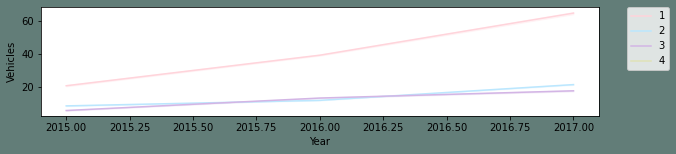

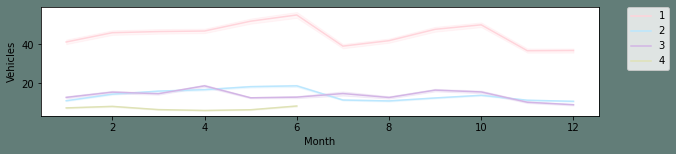

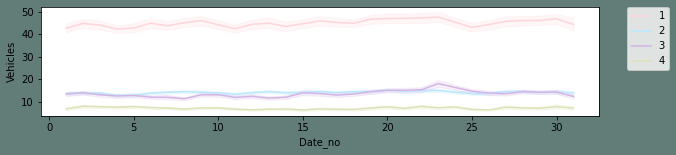

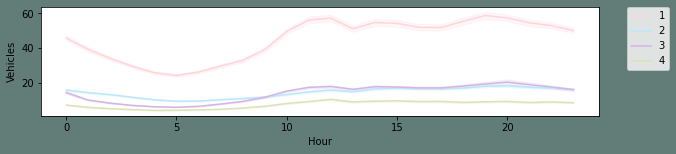

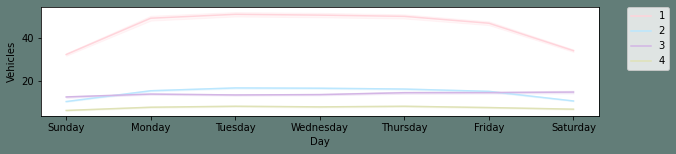

In [7]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**From the above plot following things can be concluded:**


* Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.  

* We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same. 

* Monthly, throughout all the dates there is a good consistency in data. 

* For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation. 

* For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady. 


Text(0.5, 0, 'Date')

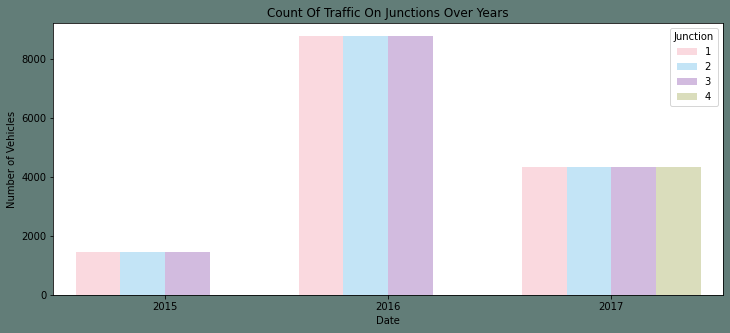

In [8]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month. 

<AxesSubplot:>

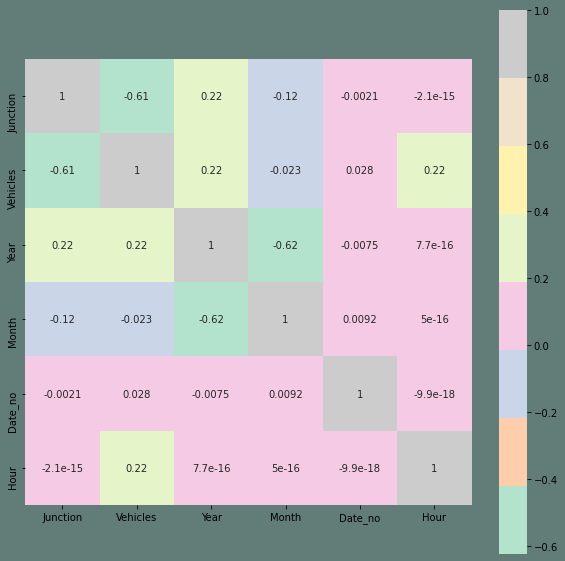

In [9]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

The highest correlation is certainly with the preexisting feature. 

I will conclude my EDA with a pair plot. It's an interesting overall representation of any data. 

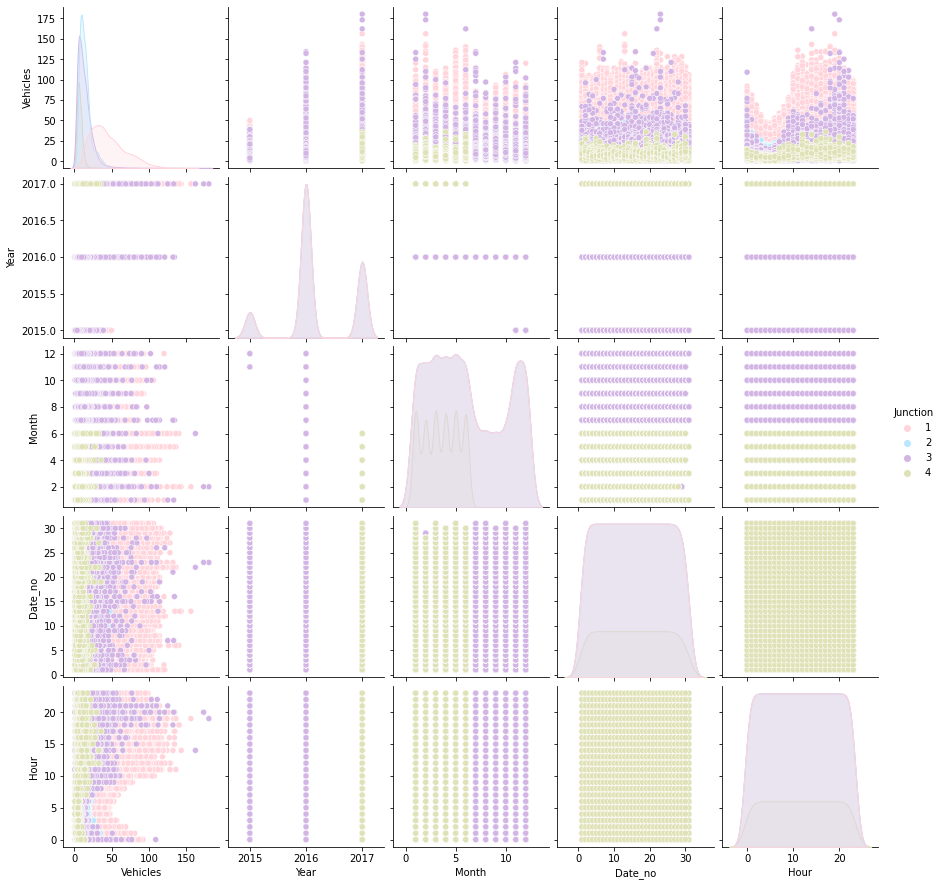

In [10]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

**Conclusions that I have come to draw after this EDA**

* The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
* The yearly trend for Junctions one, two and three have diffrent slopes. 
* Junction number one has a more strong weekly seasonality in comparison to the other junctions. 

For the above-postulated reasons, I think that junctions must be transformed as per their individual needs. 



<a id="4"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Data Transformation And Preprocessing</p>

**In this step I will be following the subsequent order:**

* Creating different frames for each Junction and plotting them
* Transforming the series and plotting them
* Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
* Creating test and train sets


In [11]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

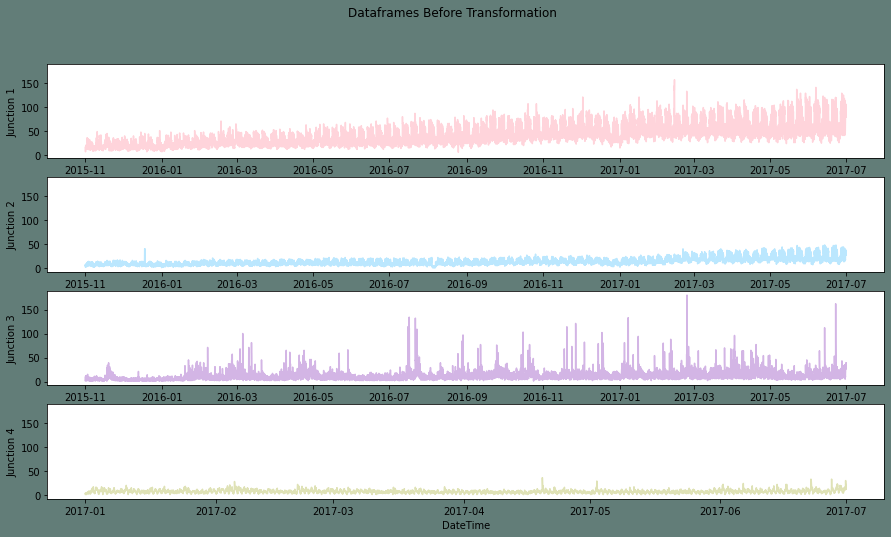

In [12]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

**Steps for Transforming:**
* Normalizing 
* Differencing 

In [13]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:
* For Junction one, I will be taking a difference of weekly values. 
* For junction two, The difference of consecutive days is a better choice
* For Junctions three and four, the difference of the hourly values will serve the purpose. 

In [14]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

**Plots of Transformed Dataframe**

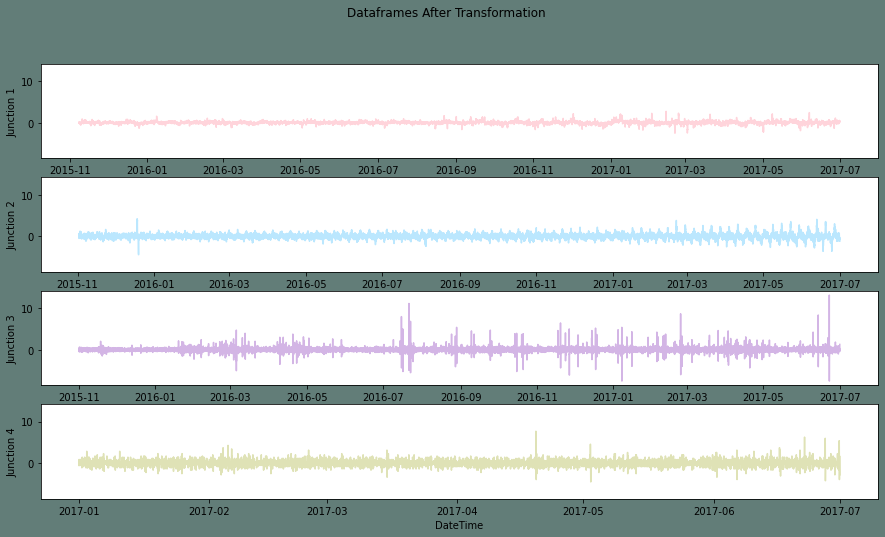

In [15]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

The plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test. 

In [16]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415458
p-value: 4.798539876396407e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940097
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832778
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305229
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


**Now that the data is stationary,  preprocessing the data for the neural net by:**

* Splitting the test train sets
* Assigning X as features and y as target 
* Reshaping data for neural net

In [17]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

<a id="5"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Model Building</p>

For this project, I have settled to use Gated Recurrent Unit (GRU). In this section, I am creating a function for the neural net to call on and fit the data frames for all four junctions. 

In [18]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

<a id="6"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Fitting The Model</p>

Now, I will be fitting the transformed training sets of four junctions to the model created and compare them to the transformed test sets. 

**Fitting the first junction and plotting the predictions and testset**

In [19]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 [==============================] - 13s 19ms/step - loss: 0.0880
Epoch 2/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0636
Epoch 3/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0673
Epoch 4/50
87/87 [==============================] - 2s 20ms/step - loss: 0.0638
Epoch 5/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0615
Epoch 6/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0582
Epoch 7/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0579
Epoch 8/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0596
Epoch 9/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0555
Epoch 10/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0550
Epoch 11/50
87/87 [==============================] - 2s 20ms/step - loss: 0.0573
Epoch 12/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0535
Epoch 13/50
87/87 [=================

The root mean squared error is 0.245881146563882.


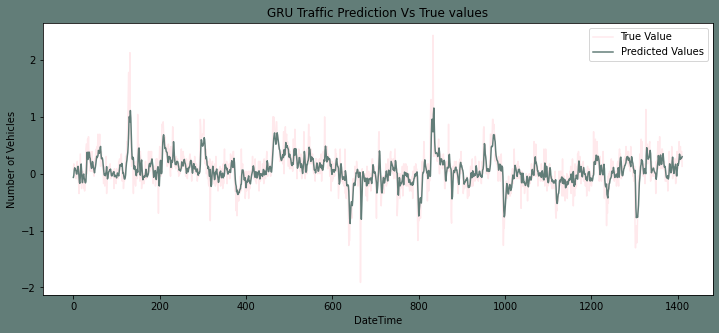

In [20]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

**Fitting the second junction and plotting the predictions and testset**

In [21]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 [==============================] - 7s 20ms/step - loss: 0.2590
Epoch 2/50
88/88 [==============================] - 2s 20ms/step - loss: 0.2103
Epoch 3/50
88/88 [==============================] - 2s 20ms/step - loss: 0.2118
Epoch 4/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1965
Epoch 5/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1974
Epoch 6/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1930
Epoch 7/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1874
Epoch 8/50
88/88 [==============================] - 2s 20ms/step - loss: 0.1869
Epoch 9/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1920
Epoch 10/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1859
Epoch 11/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1939
Epoch 12/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1878
Epoch 13/50
88/88 [==================

The root mean squared error is 0.5585970393765944.


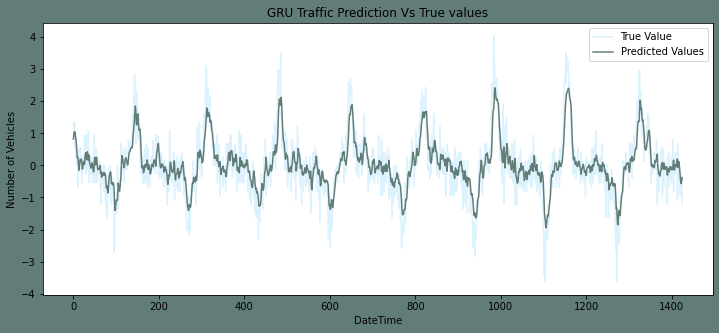

In [22]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

**Fitting the third junction and plotting the predictions and testset**

In [23]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
88/88 [==============================] - 7s 20ms/step - loss: 0.3234
Epoch 2/50
88/88 [==============================] - 2s 19ms/step - loss: 0.2939
Epoch 3/50
88/88 [==============================] - 2s 19ms/step - loss: 0.2770
Epoch 4/50
88/88 [==============================] - 2s 19ms/step - loss: 0.3008
Epoch 5/50
88/88 [==============================] - 2s 22ms/step - loss: 0.2768
Epoch 6/50
88/88 [==============================] - 2s 19ms/step - loss: 0.3103
Epoch 7/50
88/88 [==============================] - 2s 19ms/step - loss: 0.2884
Epoch 8/50
88/88 [==============================] - 2s 19ms/step - loss: 0.2932
Epoch 9/50
88/88 [==============================] - 2s 19ms/step - loss: 0.2655
Epoch 10/50
88/88 [==============================] - 2s 19ms/step - loss: 0.2685
Epoch 11/50
88/88 [==============================] - 2s 20ms/step - loss: 0.2912
Epoch 12/50
88/88 [==============================] - 2s 19ms/step - loss: 0.2671
Epoch 13/50
88/88 [==================

The root mean squared error is 0.6061366783632264.


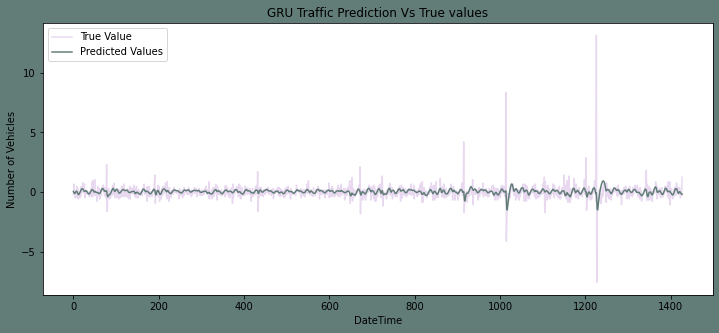

In [24]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

**Fitting the fourth junction and plotting the predictions and testset**

In [25]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 [==============================] - 6s 20ms/step - loss: 0.6857
Epoch 2/50
26/26 [==============================] - 0s 19ms/step - loss: 0.6652
Epoch 3/50
26/26 [==============================] - 0s 19ms/step - loss: 0.6726
Epoch 4/50
26/26 [==============================] - 1s 20ms/step - loss: 0.7004
Epoch 5/50
26/26 [==============================] - 1s 20ms/step - loss: 0.6753
Epoch 6/50
26/26 [==============================] - 0s 19ms/step - loss: 0.6734
Epoch 7/50
26/26 [==============================] - 0s 19ms/step - loss: 0.6818
Epoch 8/50
26/26 [==============================] - 1s 19ms/step - loss: 0.6738
Epoch 9/50
26/26 [==============================] - 0s 19ms/step - loss: 0.6579
Epoch 10/50
26/26 [==============================] - 0s 19ms/step - loss: 0.7013
Epoch 11/50
26/26 [==============================] - 1s 19ms/step - loss: 0.6751
Epoch 12/50
26/26 [==============================] - 1s 19ms/step - loss: 0.7106
Epoch 13/50
26/26 [==================

The root mean squared error is 1.0241982484501175.


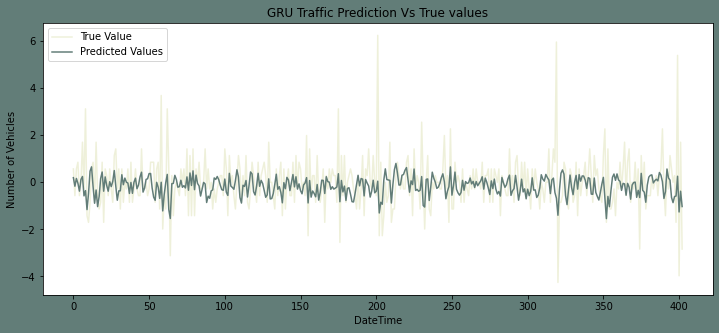

In [26]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

**The results of the model** 

In [27]:
#Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
list_of_tuples = list(zip(Junctions, RMSE))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")   


,Junction,RMSE
0,Junction1,0.245881
1,Junction2,0.558597
2,Junction3,0.606137
3,Junction4,1.024198


**The Root Mean Square Error is quite a subjective marker for evaluating the performance. 
Thus, in this project, I am including the outcome plots as well.**

<a id="7"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Inversing The Transformation Of Data</p>

In this section, I will be inversing transforms that I applied to the datasets to remove the seasonality and trends. 
Performing this step will make the predictions get back on the accurate scale. 

Resource to the inversion process [Link](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/)

In [28]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

**the inverse transform on the first junction**

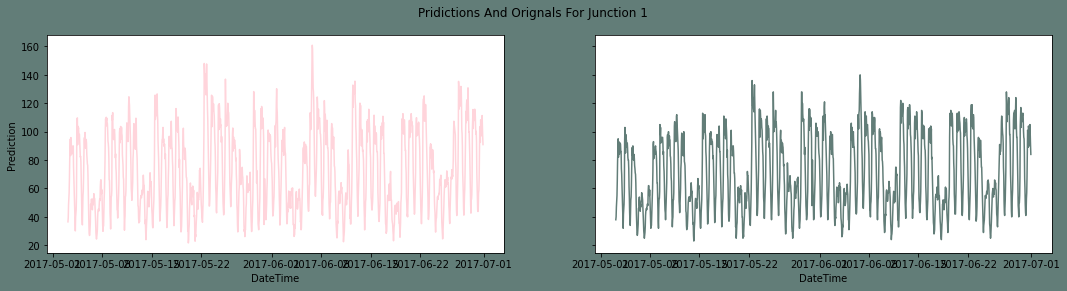

In [29]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

**the inverse transform on the second junction**

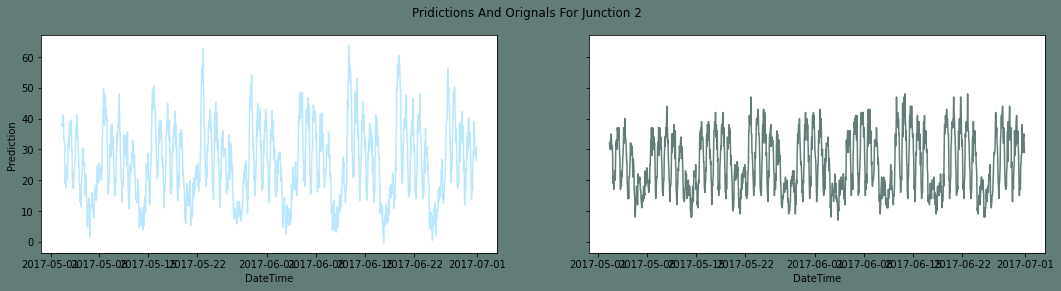

In [30]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

**The inverse transform on the third junction**

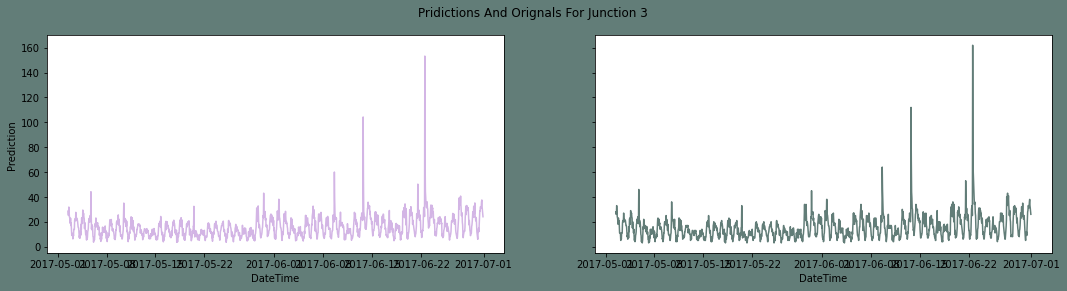

In [31]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

**The inverse transform on the fourth junction**

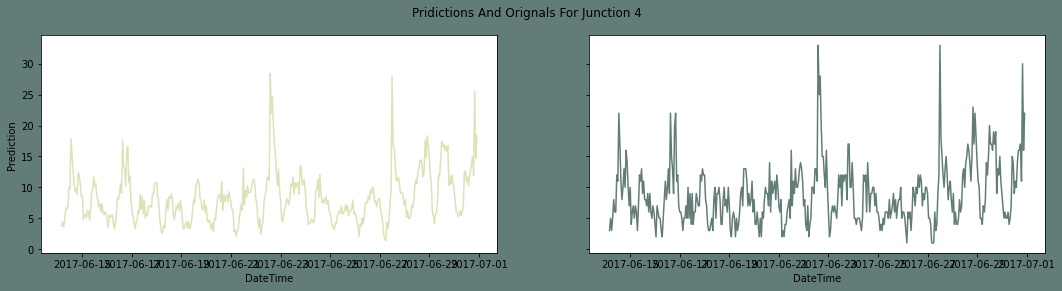

In [32]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)

**Summary**

*In this project, I trained a GRU Neural network to predicted the traffic on four junctions. 
I used a normalisation and differencing transform to achieve a stationary timeseries. As the Junctions varry in trends and seasonality, I took diffrent approach for each junction to make it stationary. I applyied the root mean squred error as the evaluation metric for the model. In addition to that I plotted the Predictions alongside the original test values.
Take aways from the data analysis:*

*The Number of vehicles in Junction one is rising more rapidly compaired to junction two and three. The sparsity of data in juction four bars me from making any conclusion on the same.*

*The Junction one's traffic has a stronger weekly seasonality as well as hourly seasonality. Where as other junctions are significantly linear.*

**<span style="color:#627D78;"> If you liked this Notebook, please do upvote.</span>**

**<span style="color:#627D78;"> Best Wishes!</span>**

<a id="8"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">End</p>